In [64]:
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics 

randomState = 42

In [65]:
dfReviews = pd.read_json("./data/IMDB_reviews.json", orient = "records", lines = True)
dfLinks = pd.read_csv("./data/links.csv")
dfMovies = pd.read_csv("./data/movies.csv")
dfUsers = pd.read_csv("./data/users.csv")
dfTrain = pd.read_csv("./data/train.csv")
dfTest = pd.read_csv("./data/test.csv")


In [66]:
def printDfInfo(df, name):
    print("{} dataframe:".format(name))
    df.info()
    #print(df.head())
    print()
    
printDfInfo(dfReviews, "Reviews")
printDfInfo(dfLinks, "Links")
printDfInfo(dfMovies, "Movies")
printDfInfo(dfUsers, "Users")
#printDfInfo(dfTrain, "Training")
#printDfInfo(dfTest, "Test")


Reviews dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB

Links dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB

Movies dataframe:
<class 'pandas.core.f

In [67]:
# Add imdbId column to dfReviews
dfReviews.insert(1, "imdbId", np.int64(dfReviews.movie_id.str.strip('tt')), True)
dfReviews.head()


,review_date,imdbId,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,111161,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,111161,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,111161,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,111161,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,111161,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [68]:
# Drop unneeded columns
dfReviews.drop(['review_date', 'user_id', 'is_spoiler', 'rating', 'review_summary'], axis = 1, inplace = True)
dfMovies.drop(dfMovies.iloc[:, 2:21], axis = 1, inplace = True)
dfMovies.head()


,mID,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [69]:
def collectReviews():
    dfMovies['all_reviews'] = ""
    for index in range(len(dfMovies)):
        allReviews = ""
        for imdbId in dfLinks[dfLinks.movieId == dfMovies.iloc[index, 0]].imdbId:
            for review in dfReviews[dfReviews.imdbId == imdbId].review_text:
                allReviews += (review + " ")
            if len(allReviews) > 0:
                dfMovies.iloc[index, 2] = allReviews
            else:
                dfMovies.iloc[index, 2] = np.nan

collectReviews()
dfMovies.dropna(axis = 0, how = 'any', subset = ["all_reviews"], inplace = True)
dfMovies.info()
dfMovies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 3879
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mID          595 non-null    int64 
 1   title        595 non-null    object
 2   all_reviews  595 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.6+ KB


,mID,title,all_reviews
0,1,Toy Story,Toy Story  5/5 starsChildren play with toys. ...
1,2,Jumanji,There are few children's movies that I particu...
5,6,Heat,I remember seeing this in my childhood and bei...
6,7,Sabrina,They don't make 'em like they used to. In fact...
9,10,GoldenEye,I hated this one. There were just too many imp...


In [70]:
dfMovies.all_reviews.replace(to_replace = "’", value = "\'", inplace = True, regex = True)
dfMovies.all_reviews.replace(to_replace = "\\d+", value = "", inplace = True, regex = True)


In [71]:
nTopWords = 60
tf_vectorizer = CountVectorizer(max_df = 0.80, min_df = 2, max_features = nTopWords, stop_words = "english")
tf = tf_vectorizer.fit_transform(dfMovies.all_reviews)     


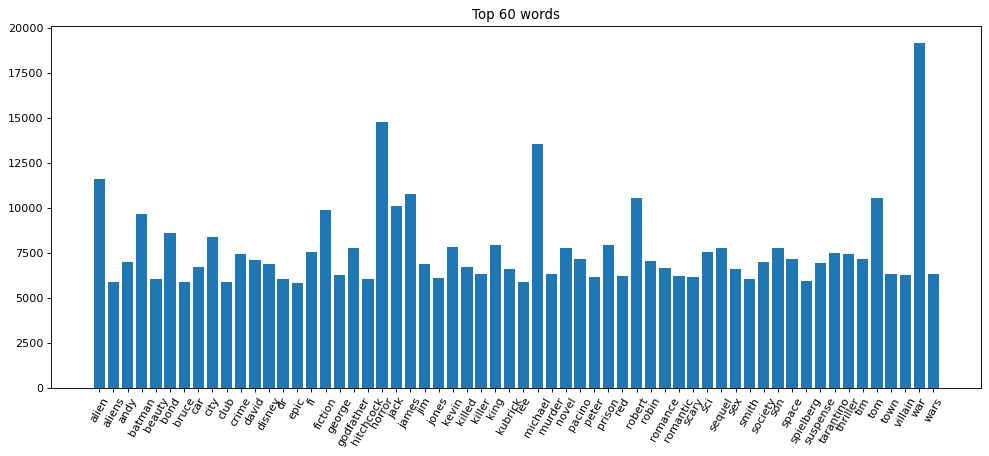

In [72]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
plt.title("Top {} words".format(nTopWords))
plt.bar(x = tf_vectorizer.get_feature_names_out(), height = np.sum(tf.toarray(), axis=0))
plt.xticks(rotation = 60)
plt.show() 

In [73]:
dfMovies.all_reviews = dfMovies.all_reviews.transform(lambda review: review.lower())
dfMovies.all_reviews.replace(to_replace = "\\bsci.?fi\\b", value = "scifi", inplace = True, regex = True)
for word in ("andy", "bruce", "edward", "david", "dr", "george", "jack" "james", "jim", "kevin", \
             "michael", "peter", "robert", "robin", "smith", "tim", "tom"):
    dfMovies.all_reviews.replace(to_replace = "\\b" + word + "\\b", value = "", inplace = True, regex = True)


In [74]:
dfTrain = dfTrain[dfTrain['mID'].isin(dfMovies['mID'])]

In [82]:
def fitNMF(tfidf, n_topicLabels, alpha, lossFunc, solverArg):
    #print("Fitting the NMF model with {} loss function and solver {}".format(lossFunc, solverArg))
    nmf = NMF(
        n_components = n_topicLabels,
        random_state = randomState,
        init = "nndsvda",
        beta_loss = lossFunc,
        solver = solverArg,
        max_iter = 1000,
        alpha_W = alpha,
        alpha_H = alpha,
        l1_ratio = 0.5,
    ).fit(tfidf)
    return nmf

nClusters = 18

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df = 0.80, min_df = 2, max_features = 1000, stop_words = "english")

tfidfTrans = tfidf_vectorizer.fit_transform(dfMovies.all_reviews)
nmfFit = fitNMF(tfidfTrans, nClusters, 0.00005, "kullback-leibler", "mu")

nmfTrans = nmfFit.transform(tfidfTrans)


Extracting tf-idf features for NMF...


In [83]:
mid2idx = dict(zip(dfMovies.mID, list(range(len(dfMovies)))))
idx2Mid = dict(zip(list(range(len(dfMovies))), dfMovies.mID))
cosDist = distance.pdist(nmfTrans, metric = 'cosine')
cosDist[np.isnan(cosDist)] = 0
cosSim = ((1 - distance.squareform(cosDist)) * .5) + .5


In [84]:
print(len(dfReviews.movie_id.unique()))
print(len(dfTrain[dfTrain.rating == 5]))

1572
84917


In [85]:
print(len(dfTrain[dfTrain.rating == 5]))

84917


In [86]:
def findSimilar(cosSim, mID):
    movieIDs = {} 
    [movieIDs.setdefault(i, []) for i in range(1, 6)] 

    mIndex = mid2idx[mID]

    sortedSim = np.argsort(cosSim[mIndex])
    for i in range(len(sortedSim) - 1, -1, -1):
        if idx2Mid[sortedSim[i]] == mID:
            continue

        itemSim = cosSim[mIndex, sortedSim[i]]
        if (itemSim >= .9):
            movieIDs[5].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .8):
            movieIDs[4].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .7):
            movieIDs[3].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .6):
            movieIDs[2].append(idx2Mid[sortedSim[i]])
        else:
            movieIDs[1].append(idx2Mid[sortedSim[i]])
    return movieIDs

def showTopN(movieID, dictMovies, nTop = 5):
    print()
    print("Movies like: {}".format(dfMovies[dfMovies.mID == movieID].title.to_string(index=False)))
    for rank in range(5, 0, -1):
        line = "Rank {}: ".format(rank)
        for i in range(min(nTop, len(dictMovies[rank]))):
            movie = dfMovies.loc[dfMovies["mID"] == dictMovies[rank][i]]
            #line += movie.mID.to_string(index=False) + ": " 
            line += movie.title.to_string(index=False) + "; "
        print(line)
        
mId = 1

for mId in dfMovies.head(25).mID:
    simMovieIDs = findSimilar(cosSim, mId)
    showTopN(mId, simMovieIDs, 10)
#simMovieIDs = findSimilar(cosSim, mId)
#showTopN(mId, simMovieIDs)
#dfMovies.head(25)


Movies like: Toy Story
Rank 5: Harlem; Land Before Time III: The Time of the Great Giving; Sixth Man, The; Mamma Roma; Garden of Finzi-Contini, The (Giardino dei Finz...; Hour of the Pig, The; Freedom for Us (� nous la libert� ); Condition Red; M*A*S*H; Aparajito; 
Rank 4: Small Soldiers; Doctor Dolittle; Borrowers, The; Teenage Mutant Ninja Turtles; Three Musketeers, The; Newsies; Chicken Run; Little Princess, A; Casper; Super Mario Bros.; 
Rank 3: Black Beauty; Nightmare Before Christmas, The; Spawn; Cool Runnings; Teenage Mutant Ninja Turtles II: The Secret of ...; Remember the Titans; Wizard of Oz, The; D2: The Mighty Ducks; Jumanji; Flintstones, The; 
Rank 2: All About Eve; Sleepless in Seattle; Long Kiss Goodnight, The; Death Becomes Her; League of Their Own, A; Die Hard: With a Vengeance; Groundhog Day; Matilda; White Men Can't Jump; Ref, The; 
Rank 1: Fifth Element, The; Thelma & Louise; Mortal Kombat; Home Alone 3; Indecent Proposal; Gremlins 2: The New Batch; Mimic; Santa Cl

Rank 5: Mountain Eagle, The; Trial, The (Le Proc�s); Transformers: The Movie, The; Prerokbe Ognja; Poison Ivy II; Freedom for Us (� nous la libert� ); Aladdin and the King of Thieves; Price of Glory; Blue Angel, The (Blaue Engel, Der); Solar Crisis; 
Rank 4: Island of Dr. Moreau, The; Doors, The; Fear and Loathing in Las Vegas; Back to the Future; 
Rank 3: There's Something About Mary; Wyatt Earp; Nightmare Before Christmas, The; Con Air; Pagemaster, The; 
Rank 2: Dick Tracy; Spawn; One Flew Over the Cuckoo's Nest; Mask of Zorro, The; Evita; X-Men; My Best Friend's Wedding; Mortal Kombat; Teenage Mutant Ninja Turtles; Three Musketeers, The; 
Rank 1: Prince of Egypt, The; 10 Things I Hate About You; Ref, The; Anastasia; Shining, The; Almost Famous; Donnie Brasco; Santa Clause, The; Jingle All the Way; Heat; 

Movies like: Powder
Rank 5: Prerokbe Ognja; Price of Glory; Mountain Eagle, The; Puppet Master II; Puppet Master; Trial, The (Le Proc�s); Condition Red; Return of Jafar, The; Midaq

Rank 4: Newsies; Three Musketeers, The; Little Princess, A; Space Jam; Casper; Black Beauty; Super Mario Bros.; Flintstones, The; Spawn; Nightmare Before Christmas, The; 
Rank 3: Teenage Mutant Ninja Turtles II: The Secret of ...; Wizard of Oz, The; Rocketeer, The; Jumanji; Tank Girl; 13th Warrior, The; Ghost in the Shell (Kokaku kidotai); Muppet Christmas Carol, The; Matilda; Robin Hood: Men in Tights; 
Rank 2: Stand by Me; Parent Trap, The; Secret Garden, The; Fly Away Home; Mummy, The; Dick Tracy; Man in the Iron Mask, The; Hook; Hocus Pocus; Braveheart; 
Rank 1: Last of the Mohicans, The; Remember the Titans; Life Is Beautiful (La Vita � bella); Great Escape, The; Snow Day; Elizabeth; Deer Hunter, The; Ran; Santa Clause, The; Seven Samurai (The Magnificent Seven) (Shichini...; 

Movies like: Usual Suspects, The
Rank 5: Land Before Time III: The Time of the Great Giving; Slaughterhouse 2; Garden of Finzi-Contini, The (Giardino dei Finz...; Puppet Master II; Puppet Master; Where Eagl

In [87]:
print((cosSim < .50).any())

False
